<a href="https://colab.research.google.com/github/sumyat196/Bird-species-classifier/blob/main/Bird_Species_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install --upgrade tensorflow

In [ ]:
# Upgrade TensorFlow and Keras
!pip install --upgrade tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [ ]:
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast

In [ ]:
# System libraries
from pathlib import Path
import os.path
import random

In [ ]:
# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

In [ ]:
sns.set_style('darkgrid')

In [ ]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot


--2024-08-26 16:43:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-26 16:43:36 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
folder_path = '/content/drive/MyDrive/Train_birds'

In [ ]:
for file_name in os.listdir(folder_path):
    print(file_name)


CAMPO FLICKER
AFRICAN CROWNED CRANE
BALD EAGLE
KAGU
GOLDEN EAGLE


In [ ]:
image_dir = Path(folder_path)
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

<ipython-input-15-c3413c2a95eb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.7, palette='dark:salmon_r')


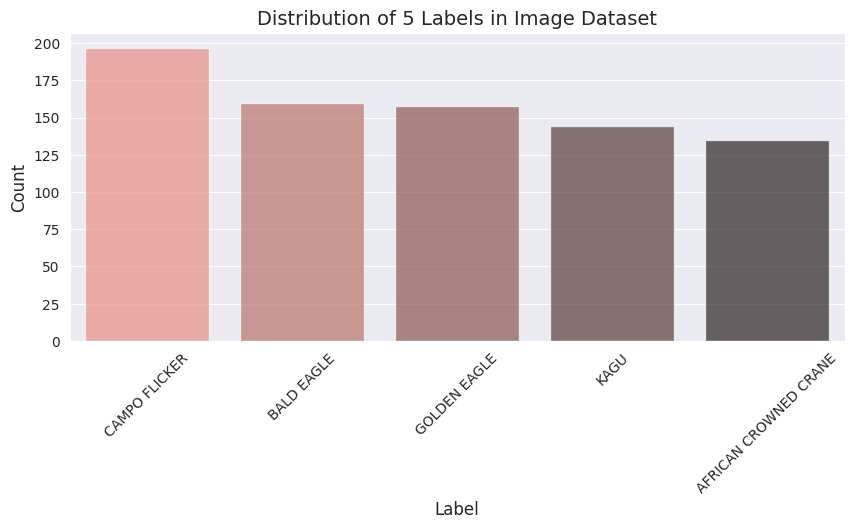

In [ ]:
# Get the labels
label_counts = image_df['Label'].value_counts()[:5]

plt.figure(figsize=(10, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.7, palette='dark:salmon_r')
plt.title('Distribution of 5 Labels in Image Dataset', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

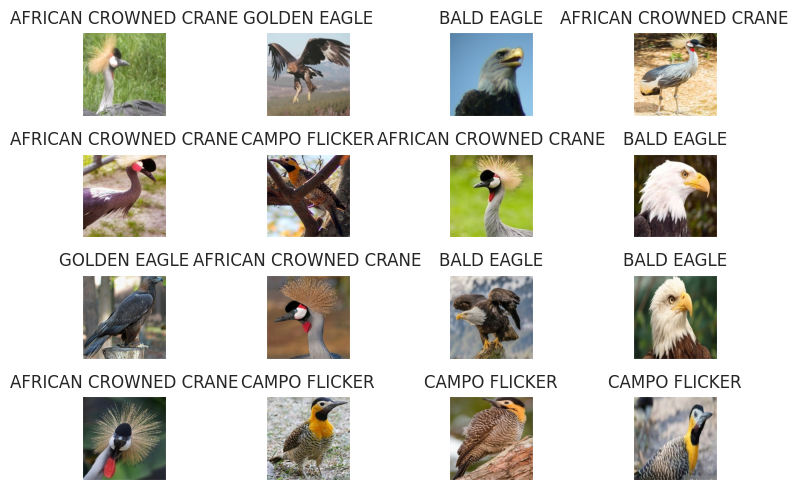

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 508 validated image filenames belonging to 5 classes.


In [ ]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 127 validated image filenames belonging to 5 classes.


In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 159 validated image filenames belonging to 5 classes.


In [ ]:
augment = Sequential([
    Resizing(224, 224),           # Resize the images to 224x224
    Rescaling(1./255),            # Rescale pixel values to [0, 1]
    RandomFlip("horizontal"),     # Randomly flip images horizontally
    RandomRotation(0.1),          # Randomly rotate images by 10%
    RandomZoom(0.1),              # Randomly zoom images by 10%
    RandomContrast(0.1)           # Randomly adjust contrast by 10%
])

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Initialize counters for each layer type
conv_layers = 0
pooling_layers = 0
dense_layers = 0

In [ ]:
# Iterate through each layer in the model
for layer in pretrained_model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        conv_layers += 1
    elif isinstance(layer, (tf.keras.layers.MaxPooling2D, tf.keras.layers.AveragePooling2D, tf.keras.layers.GlobalMaxPooling2D, tf.keras.layers.GlobalAveragePooling2D)):
        pooling_layers += 1
    elif isinstance(layer, tf.keras.layers.Dense):
        dense_layers += 1

print(f"Number of Convolutional layers: {conv_layers}")
print(f"Number of Pooling layers: {pooling_layers}")
print(f"Number of Dense layers: {dense_layers}")

Number of Convolutional layers: 65
Number of Pooling layers: 17
Number of Dense layers: 0


In [ ]:
# Create checkpoint callback
checkpoint_path = "birds_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling_1[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_2[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,247,848 (16.20 MB)

 Trainable params: 198,277 (774.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
print(len(pretrained_model.layers))


239


In [ ]:
for data in val_images:
    images, labels = data
    print(images.shape, labels.shape)
    break


(32, 224, 224, 3) (32, 5)


In [ ]:
#tensorboard_callback = TensorBoard(log_dir="training_logs/bird_classification")

In [ ]:
steps_per_epoch = train_images.n // train_images.batch_size
validation_steps = val_images.n // val_images.batch_size

In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_images,
    validation_steps=validation_steps,
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "bird_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)


Saving TensorBoard log files to: training_logs/bird_classification/20240826-171452
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 371s 14s/step - accuracy: 0.2027 - loss: 5.8618 - val_accuracy: 0.5833 - val_loss: 0.9754 - learning_rate: 1.0000e-04
Epoch 2/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 3:19 14s/step - accuracy: 0.3214 - loss: 3.3255

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 892ms/step - accuracy: 0.3214 - loss: 3.3255 - val_accuracy: 0.4839 - val_loss: 1.4302 - learning_rate: 1.0000e-04
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.3270 - loss: 2.9286 - val_accuracy: 0.8229 - val_loss: 0.5119 - learning_rate: 1.0000e-04
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4062 - loss: 2.4994 - val_accuracy: 0.7419 - val_loss: 0.5584 - learning_rate: 1.0000e-04
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.4816 - loss: 1.9284 - val_accuracy: 0.9167 - val_loss: 0.2882 - learning_rate: 1.0000e-04
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6250 - loss: 1.2102 - val_accuracy: 0.9355 - val_loss: 0.2741 - learning_rate: 1.0000e-04
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.5489 - loss: 1.3681 - val_accuracy: 0.9583 - val_loss: 0.2169 - learning_rate: 1.0000e-04
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6562 -

In [ ]:
results = model.evaluate(test_images, verbose=2)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

5/5 - 1s - 137ms/step - accuracy: 0.9811 - loss: 0.1665
    Test Loss: 0.16654
Test Accuracy: 98.11%


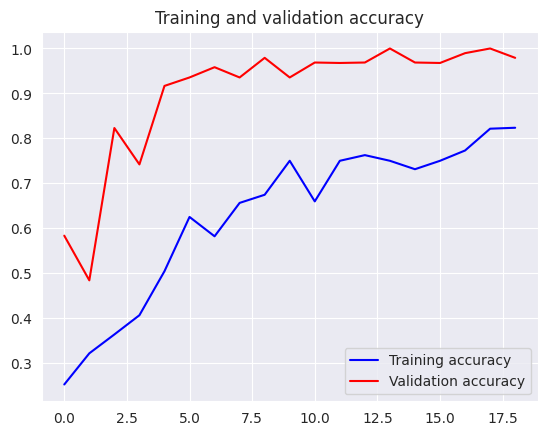

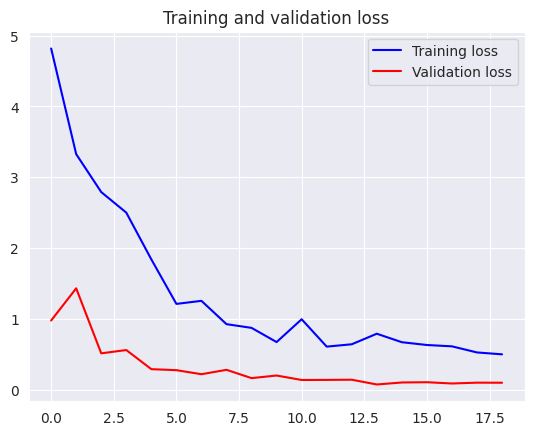

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/BetterModel.h5')
print('Model Saved!!')

Model Saved!!


In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
The first 5 predictions: ['GOLDEN EAGLE', 'GOLDEN EAGLE', 'CAMPO FLICKER', 'KAGU', 'CAMPO FLICKER']


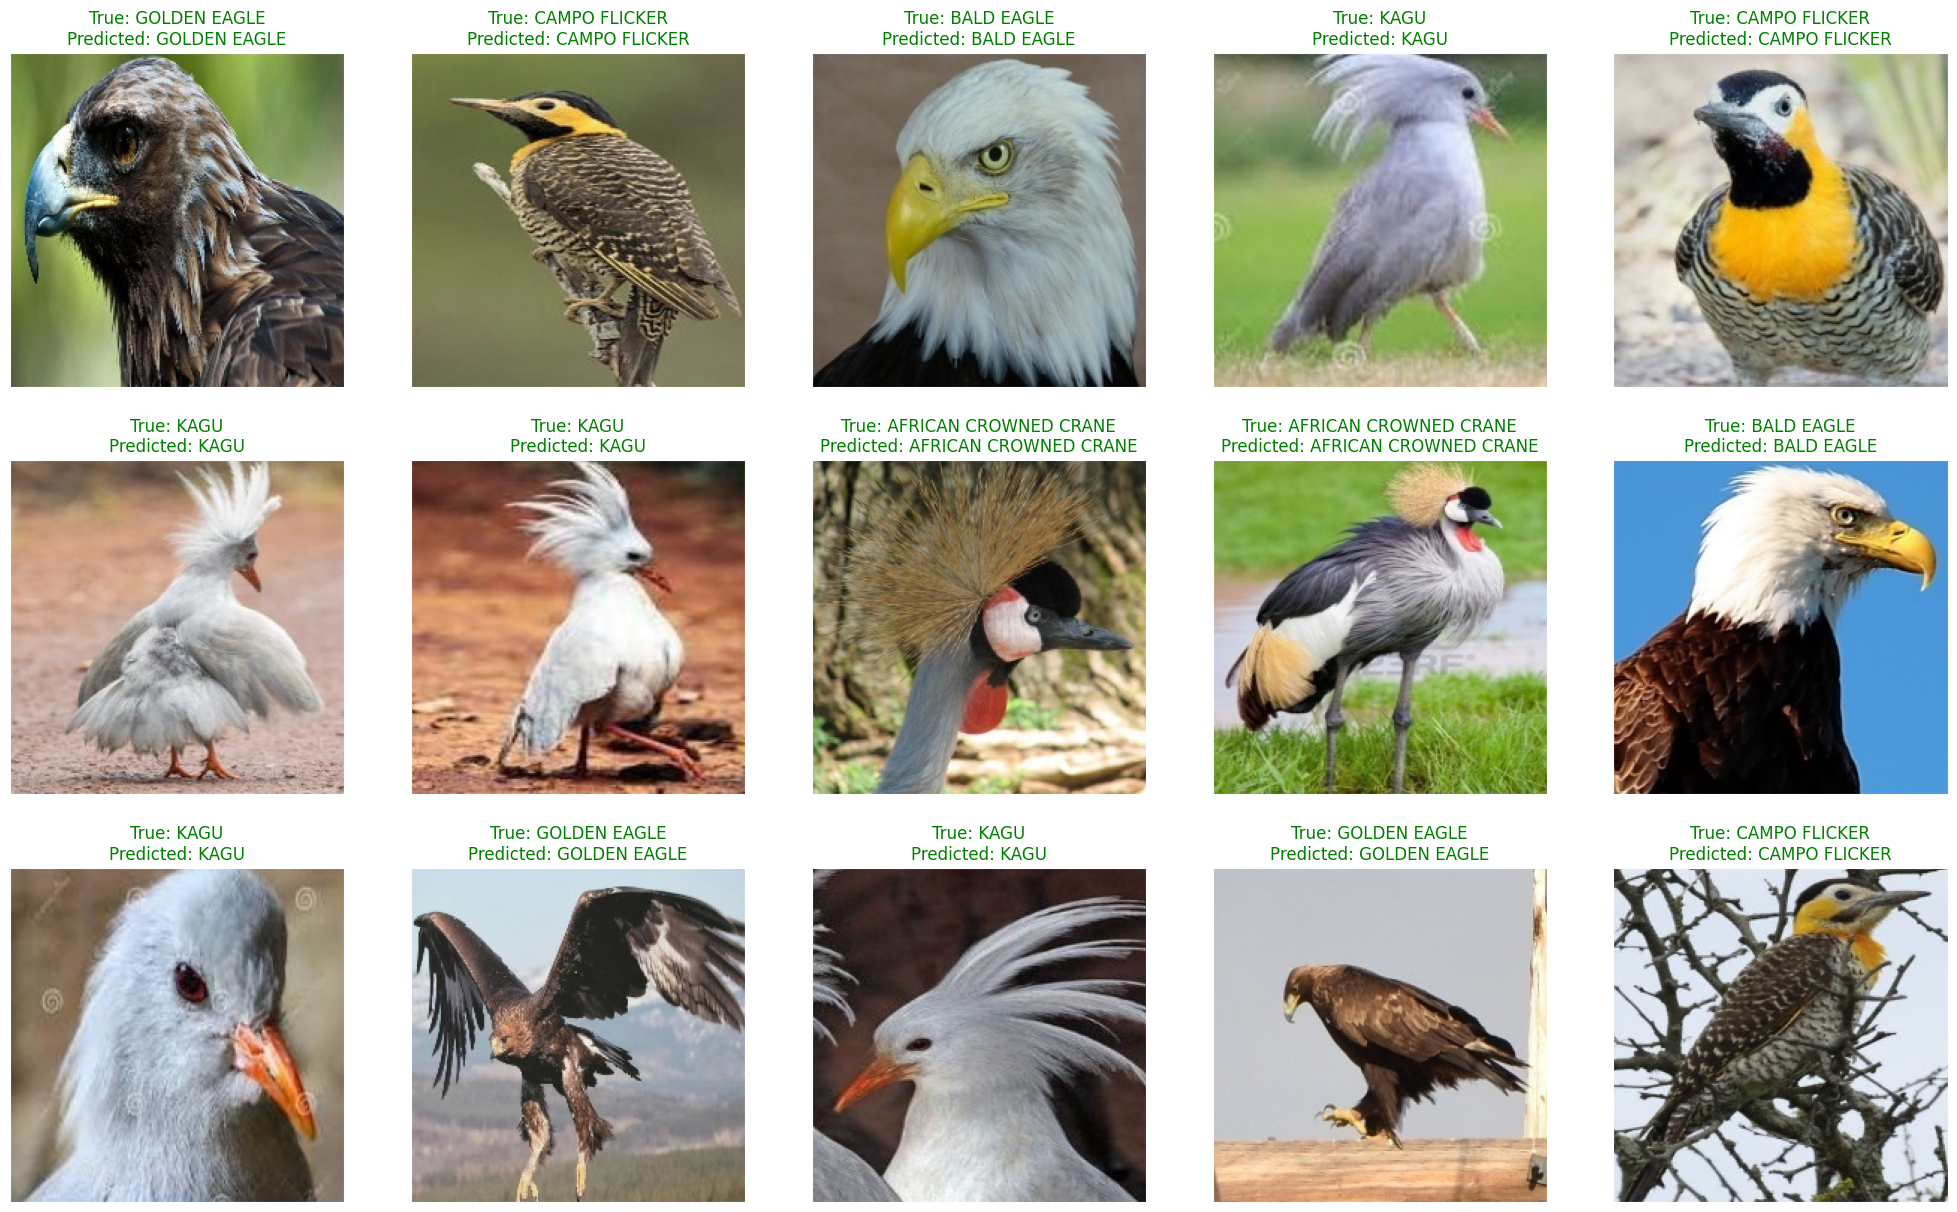

<Figure size 640x480 with 0 Axes>

In [ ]:
 # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                       precision    recall  f1-score   support

AFRICAN CROWNED CRANE       1.00      1.00      1.00        27
           BALD EAGLE       1.00      0.97      0.98        32
        CAMPO FLICKER       1.00      1.00      1.00        35
         GOLDEN EAGLE       0.97      1.00      0.99        36
                 KAGU       1.00      1.00      1.00        29

             accuracy                           0.99       159
            macro avg       0.99      0.99      0.99       159
         weighted avg       0.99      0.99      0.99       159



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
AFRICAN CROWNED CRANE   1.000000  1.000000  1.000000   27.000000
BALD EAGLE              1.000000  0.968750  0.984127   32.000000
CAMPO FLICKER           1.000000  1.000000  1.000000   35.000000
GOLDEN EAGLE            0.972973  1.000000  0.986301   36.000000
KAGU                    1.000000  1.000000  1.000000   29.000000
accuracy                0.993711  0.993711  0.993711    0.993711
macro avg               0.994595  0.993750  0.994086  159.000000
weighted avg            0.993881  0.993711  0.993704  159.000000

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

<ipython-input-40-01d28b22dfdd>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


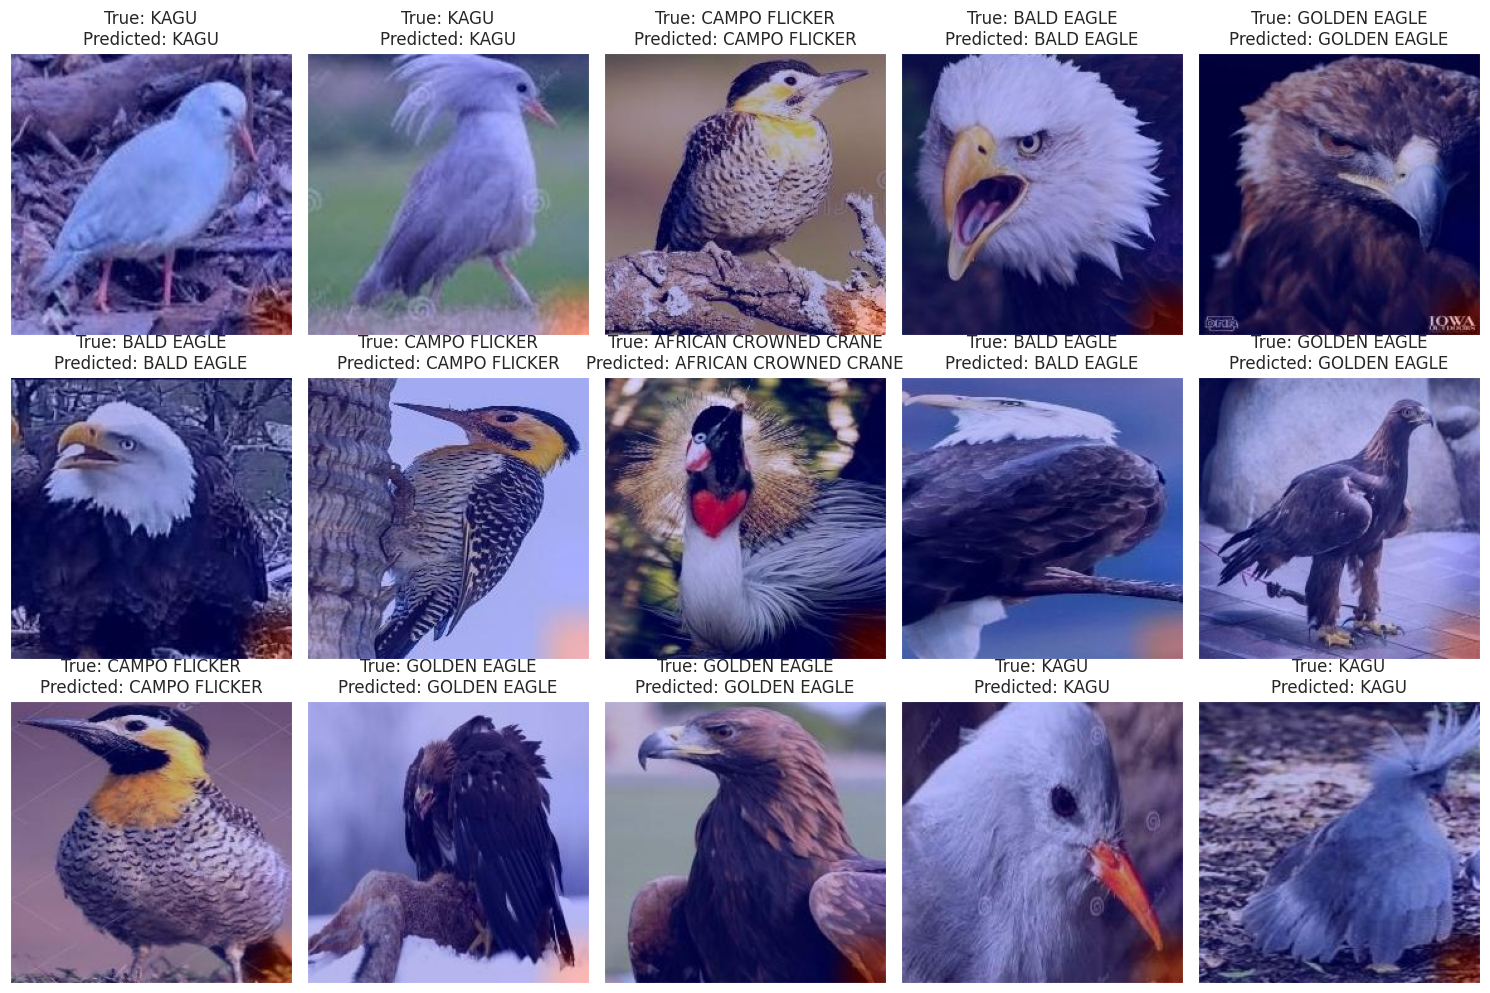

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Best_model1.h5')
print('Model Saved!!')

TypeError: argument of type 'NoneType' is not iterable

In [ ]:
for layer in model.layers:
    print(f"Layer: {layer.name}, Activation: {getattr(layer, 'activation', 'No activation')}")

Layer: input_layer, Activation: No activation
Layer: rescaling_1, Activation: No activation
Layer: normalization, Activation: No activation
Layer: rescaling_2, Activation: No activation
Layer: stem_conv_pad, Activation: No activation
Layer: stem_conv, Activation: <function linear at 0x77feb8fb0670>
Layer: stem_bn, Activation: No activation
Layer: stem_activation, Activation: <function silu at 0x77feb8fb0280>
Layer: block1a_dwconv, Activation: <function linear at 0x77feb8fb0670>
Layer: block1a_bn, Activation: No activation
Layer: block1a_activation, Activation: <function silu at 0x77feb8fb0280>
Layer: block1a_se_squeeze, Activation: No activation
Layer: block1a_se_reshape, Activation: No activation
Layer: block1a_se_reduce, Activation: <function silu at 0x77feb8fb0280>
Layer: block1a_se_expand, Activation: <function sigmoid at 0x77feb8fb0430>
Layer: block1a_se_excite, Activation: No activation
Layer: block1a_project_conv, Activation: <function linear at 0x77feb8fb0670>
Layer: block1a_pr